In [1]:
# -------------- PART 0: PYTHON PRELIM --------------

# Additional notes: 
# mosa.py evolve() function has been edited to return final stopping temperature

# Import packages
import importlib
import os
import time
from tqdm import tqdm
import itertools
import numpy as np
import json
import mosa
import matplotlib.pyplot as plt
import pyvista as pv
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from numpy import random
import pandas as pd

In [2]:
# -------------- PART 0: CHOOSE CIRCUIT AND SET UP FOLDER --------------


# Choose circuit
circuit = "ToyModel"

# Import circuit config file
config = importlib.import_module(circuit)

# Define the subfolder name
folder_name = f"MOSA_{circuit}"

# Create folder if not yet exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Jump to folder
os.chdir(folder_name)

# Prompt new folder name
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/nt625/Documents/GitHub/My5thMOSArepository_plsdontcrash/Metabolic_ToyModel/MOSA_ToyModel


In [3]:
# -------------- PART 0b: DEFINE DYNAMICAL SYSTEM --------------

# Import ODEs
Equ1 = config.Equ1
Equ2 = config.Equ2
Equ3 = config.Equ3
Equ4 = config.Equ4
    
# Define function to evaluate vector field
def Equs(P, t, params):
    x0 = P[0]
    x1 = P[1]
    e1 = P[2]
    e2 = P[3]
    k1 = params[0]
    k2 = params[1]
    theta1 = params[2]
    theta2 = params[3]
    val0 = Equ1(x0, e1)
    val1 = Equ2(x0, x1, e1, e2)
    val2 = Equ3(x1, e1, k1, theta1)
    val3 = Equ4(x1, e2, k2, theta2)
    return np.array([val0, val1, val2, val3])

# Define initial time
t = 0.0

In [13]:
# Sample rS1 values
k1_min = 0.0000001
k1_max = 0.001
k1_sampsize = 2
k1_samps = np.linspace(k1_min, k1_max, k1_sampsize)

# Sample kS1 values
k2_min = 0.0000001
k2_max = 0.001
k2_sampsize = 2
k2_samps = np.linspace(k2_min, k2_max, k2_sampsize)

# Sample kS2 values
theta1_min = 0.001
theta1_max = 10
theta1_sampsize = 2
theta1_samps = np.linspace(theta1_min, theta1_max, theta1_sampsize)

# Sample kP values
theta2_min = 0.001
theta2_max = 10
theta2_sampsize = 2
theta2_samps = np.linspace(theta2_min, theta2_max, theta2_sampsize)


In [17]:
# Create empty arrays to store ...
# ... steady states
sol_samps = np.empty((0, 4))
J_samps = np.empty((0,1))

In [18]:
# WITH LOADING BAR 
# Compute the total number of iterations for tqdm
total_iterations = k1_sampsize * k2_sampsize * theta1_sampsize * theta2_sampsize
# Loop over every combination of parameters with a progress bar
for i, j, k, l in tqdm(itertools.product(k1_samps, k2_samps, theta1_samps, theta2_samps), total=total_iterations, desc="Loading:"):
    
    # Get steady states and store

    # Constants
    V_in = 1
    k_cat = 12
    k_m = 10

    # Initial conditions
    y0 = [2290,0,0,0]
    params = [i, j, k, l]
    t_max = 5e4 
    t_eval = np.linspace(0, t_max, 10000)

    # Run the integration
    sol = solve_ivp(lambda t, y: Equs(y, t, params),
                    t_span=[0, t_max], 
                    y0=y0,
                    t_eval=t_eval,
                    rtol=1e-8, 
                    atol=1e-10)
    
    # sol_samps = np.vstack([sol_samps, sol.y[:, -1]])

    #-----------

    t_used = sol.t
    x1_vals = sol.y[1]  # x1(t)
    e2_vals = sol.y[3]  # e2(t)

    # Compute integrand at each time point
    integrand_vals = np.abs(V_in - e2_vals * (k_cat * x1_vals) / (k_m + x1_vals))
    
    # Compute the integral numerically using trap rule
    integral_val = np.trapz(integrand_vals, t_used)

    J_samps = np.vstack([J_samps, integral_val])

Loading:: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


In [19]:
J_samps

array([[49999.99681853],
       [49999.35771183],
       [49999.91229495],
       [49924.0396454 ],
       [49860.5516994 ],
       [49810.37155999],
       [49853.38576519],
       [49722.56932285],
       [49999.99865133],
       [49977.72858047],
       [49999.99722162],
       [49999.50342969],
       [49989.04166964],
       [44020.17648343],
       [49972.52297501],
       [ 3826.9479801 ]])

In [7]:
sol_samps

array([[2.29031113e+03, 3.17077307e-02, 5.14280224e-07, 5.14280224e-07],
       [2.29026041e+03, 1.96522042e-02, 1.33806048e-06, 5.18093300e-04],
       [2.29026041e+03, 1.96521462e-02, 1.33806838e-06, 5.18099312e-04],
       [2.28199213e+03, 8.39655548e+00, 1.35630792e-04, 3.02896427e-10],
       [2.27905187e+03, 6.75567978e+00, 1.83396328e-04, 1.83396328e-04],
       [2.27607720e+03, 5.55746715e+00, 2.31800555e-04, 3.95843128e-04],
       [2.27790286e+03, 1.25084437e+01, 2.02032939e-04, 2.98863215e-10],
       [2.27631637e+03, 1.12946914e+01, 2.27713050e-04, 8.49547084e-05],
       [2.27293021e+03, 9.12062057e+00, 2.82849788e-04, 2.82849788e-04],
       [2.28392012e+03, 1.99086498e-03, 1.04381627e-04, 5.21960328e-01],
       [2.27436880e+03, 9.97776710e-04, 2.59627302e-04, 2.59076562e+00],
       [2.27436880e+03, 9.97776524e-04, 2.59627306e-04, 2.59076569e+00],
       [2.28160809e+03, 8.39033199e+00, 1.36593467e-04, 2.14189842e-06],
       [2.25846799e+03, 1.99125694e-03, 5.18101252e

(array([ 7.,  0.,  0.,  1.,  0.,  1.,  0.,  6., 19., 47.]),
 array([1.62071926e-01, 2.29176978e+02, 4.58191885e+02, 6.87206791e+02,
        9.16221697e+02, 1.14523660e+03, 1.37425151e+03, 1.60326642e+03,
        1.83228132e+03, 2.06129623e+03, 2.29031113e+03]),
 <BarContainer object of 10 artists>)

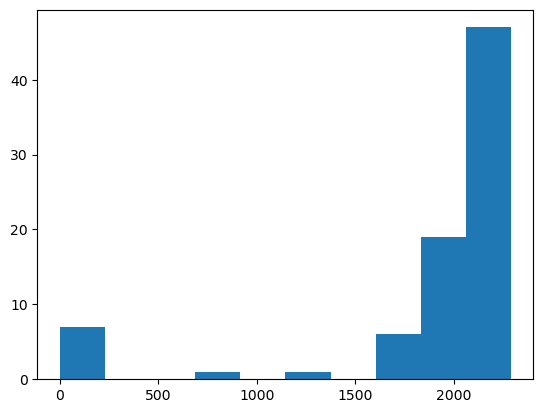

In [8]:
plt.hist(sol_samps[:,0])

(array([52.,  0.,  2.,  1.,  1.,  5.,  6.,  6.,  1.,  7.]),
 array([6.80509244e-04, 3.17345325e+01, 6.34683846e+01, 9.52022366e+01,
        1.26936089e+02, 1.58669941e+02, 1.90403793e+02, 2.22137645e+02,
        2.53871497e+02, 2.85605349e+02, 3.17339201e+02]),
 <BarContainer object of 10 artists>)

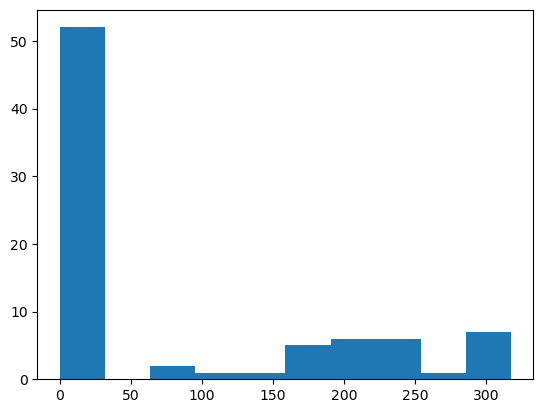

In [9]:
plt.hist(sol_samps[:,1])

(array([74.,  0.,  0.,  0.,  3.,  1.,  0.,  0.,  0.,  3.]),
 array([5.14280224e-07, 5.17822462e-01, 1.03564441e+00, 1.55346636e+00,
        2.07128831e+00, 2.58911025e+00, 3.10693220e+00, 3.62475415e+00,
        4.14257610e+00, 4.66039805e+00, 5.17821999e+00]),
 <BarContainer object of 10 artists>)

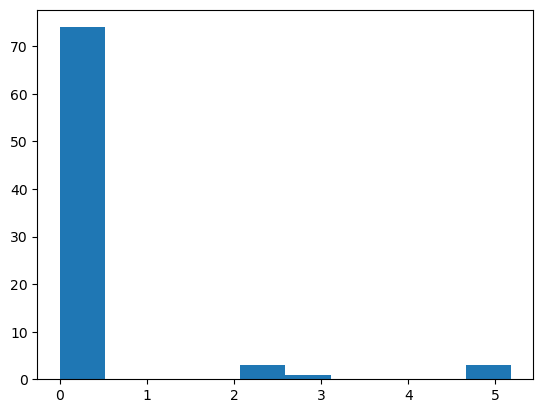

In [10]:
plt.hist(sol_samps[:,2])

(array([52.,  1.,  0.,  0.,  2., 11.,  0.,  0.,  0., 15.]),
 array([2.96565451e-12, 5.18101332e-01, 1.03620266e+00, 1.55430399e+00,
        2.07240533e+00, 2.59050666e+00, 3.10860799e+00, 3.62670932e+00,
        4.14481065e+00, 4.66291198e+00, 5.18101332e+00]),
 <BarContainer object of 10 artists>)

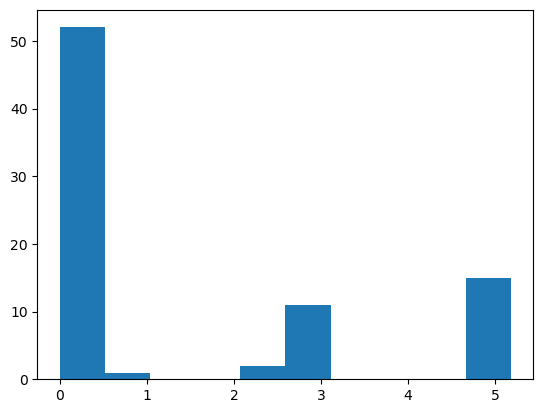

In [11]:
plt.hist(sol_samps[:,3])

In [12]:
    #-------------------- J -----------------------

    # Constants
    V_in = 1
    k_cat = 12
    k_m = 10
    
    # Known steady state 
    steady_state = np.array([2.29031113e+03, 3.17077307e-02, 5.14280224e-07, 5.14280224e-07])
    
    # Initial conditions
    y0 = [2290,0,0,0]
    params = [0.0000001, 0.0000001, 0.001, 0.001]
    t_max = 5e4
    t_eval = np.linspace(0, t_max)
    
    # Run the integration
    sol = solve_ivp(
        fun=lambda t, y: Equs(y, t, params),
        t_span=[0, t_max],
        y0=y0,
        method='RK23',
        t_eval=t_eval,
        rtol=1e-8,
        atol=1e-10,
        dense_output=True
    )
    
    t_used = sol.t
    x1_vals = sol.y[1]  # x1(t)
    e2_vals = sol.y[3]  # e2(t)

    # Compute integrand at each time point
    integrand_vals = np.abs(V_in - e2_vals * (k_cat * x1_vals) / (k_m + x1_vals))
    
    # Compute the integral numerically using trap rule
    integral_val = np.trapz(integrand_vals, t_used)
    
    print(f"Integral up to steady state: {integral_val:.6f}")   

Integral up to steady state: 49999.996844
